In [385]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer

In [50]:
#NOTES
#Compare f2 scores with boxcox(with minmax to (1,2)/yeojohnson/QuantileTransformer(minmax)
#Over vs Over+under sample
#Compare PCA vs no PCA
#GridSearch number of features for PCA & model params for LR
    #for LR gridsearch solver, penalty (L1,L2) and class weight
        #solver: liblinear, sag, saga, lbgfs
        #class weight: balanced & gridsearch

#Create model with PCA, without PCA, with any sampling adjustments, without sampling adjustments
        
#Run against roc_auc?

In [298]:
X = pd.read_csv('X.csv')
y = pd.read_csv('y.csv')
y = y.values.ravel()

In [299]:
#Creating just temporary small samples
X_train, _, y_train, __ = train_test_split(X, y, test_size=.99, stratify=y, random_state=42)

In [55]:
num_transform = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('norm', PowerTransformer(method='yeo-johnson', standardize=True))
])

#BOXCOX TRANSFORM
# num_transform = Pipeline(steps=[
#     ('imputer',SimpleImputer(strategy='median')),
#     ('scale', MinMaxScaler([1,2]))
#     ('norm', PowerTransformer(method='box-cox', standardize=True))])

cat_transform = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',OneHotEncoder(handle_unknown='ignore'))
])

# CONSTANT CAT. IMPUTER
# cat_transform = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
#     ('onehot',OneHotEncoder(handle_unknown='ignore'))
# ])

In [56]:
num_ix = X.select_dtypes(['float64','int64']).columns
cat_ix = X.select_dtypes(['O']).columns

In [57]:
#Build out the column transformer

t= [
    ('categorical',cat_transform,cat_ix),
    ('numerical',num_transform,num_ix),
]

ct = ColumnTransformer(transformers=t,remainder='passthrough')

In [171]:
#Define metric used
F2 = make_scorer(fbeta_score, beta=2)
metric = F2
# metric = 'roc_auc'

In [156]:
# print(pd.Series(y_train).value_counts())

# print(len(y_train)/(2*pd.Series(y_train).value_counts().loc[0]))
# print(len(y_train)/(2*pd.Series(y_train).value_counts().loc[1]))

compute_class_weight('balanced', [0,1], y_train)

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0, 1], y=[0 0 0 ... 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


array([0.57429739, 3.86485557])

## With PCA

In [407]:
#Creating lists for param_grid

C_list = list(np.logspace(-3,3,8))
C_list.insert(4,1)
print(C_list)
print()

sampling_strategy_list = list(np.arange(.1,1.1,.1))
sampling_strategy_list.append('auto')
print(sampling_strategy_list)

[0.001, 0.0071968567300115215, 0.0517947467923121, 0.3727593720314938, 1, 2.6826957952797246, 19.306977288832496, 138.9495494373136, 1000.0]

[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9, 1.0, 'auto']


In [352]:
#Set model type
model_pca = LogisticRegression()

#Build pipeline
pipe_pca = Pipeline(steps=[
    ('preprocess',ct),
    ('oversample', SMOTE()),
    ('pca', PCA()),
    ('model_pca', model)
])

#Set gridsearch parameters
param_grid_pca = [
{'pca__n_components': list(np.arange(5,120,5)),
    'model_pca__C': C_list,
    'model_pca__penalty': ['l1'], 
    'model_pca__solver': ['liblinear', 'saga'],
    'model_pca__class_weight': ['balanced', {0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]},
{'pca__n_components': list(np.arange(5,120,5)),
    'model_pca__C': C_list,
    'model_pca__penalty': ['l2'],
    'model_pca__solver': ['lbfgs','sag','liblinear', 'saga'],
    'model_pca__class_weight': ['balanced', {0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]}
]

#Setup Kfold CV
cv_pca = RepeatedStratifiedKFold(n_splits=2, n_repeats=1, random_state=42)

grid_pca = GridSearchCV(estimator=pipe_pca, param_grid=param_grid_pca, n_jobs=-1, cv=cv_pca, scoring=metric, verbose=1)

#Fit gridsearch 
grid_result_pca = grid_pca.fit(X_train, y_train)

print(f'Best score:{grid_result_pca.best_score_}')
print(f'Best params:{grid_result_pca.best_params_}')

# report all configurations
means_pca = grid_result_pca.cv_results_['mean_test_score']
stds_pca = grid_result_pca.cv_results_['std_test_score']
params_pca = grid_result_pca.cv_results_['params']
for mean, stdev, param in zip(means_pca, stds_pca, params_pca):
    print(f'{mean:.4f} {stdev:.4f} with: {param}')

Fitting 2 folds for each of 7452 candidates, totalling 14904 fits


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/runpy.py", line 185, in _run_module_as_main
    mod_name, mod_spec, code = _get_module_details(mod_name, _Error)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/runpy.py", line 111, in _get_module_details
    __import__(pkg_name)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/__init__.py", line 113, in <module>
    from .memory import Memory, MemorizedResult, register_store_backend
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 33, in <module>
    from ._store_backends import StoreBackendBase, FileSystemStoreBackend
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/_store_backends.py", line 15, in <module>
    from .backports import concurrency_safe_rename
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/backports.py", line 13, in <module>
    import numpy as np
  File "/Users/cxa013/opt/anacon

KeyboardInterrupt: 

In [199]:
grid_result.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_model__class_weight', 'param_model__penalty', 'param_model__solver', 'param_pca__n_components', 'params', 'split0_test_score', 'split1_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [210]:
grid_result.best_estimator_.named_steps['model'].coef_

array([[-1.72702626e-01, -7.65018294e-01, -3.54665493e-01,
         1.87351151e-01,  4.19896336e-01,  4.72982146e-02,
        -7.50337853e-02,  9.03282192e-03,  1.25403819e-01,
         6.48824013e-01,  2.39990444e-02, -3.30776825e-01,
         3.20427480e-01,  2.22727414e-02, -1.32177145e-02,
         1.01407022e-01,  1.48033813e-01,  2.39483727e-03,
         1.09863004e-03, -1.30636876e+00,  9.61388891e-01,
        -5.54306259e-01,  1.44564070e+00,  1.15203950e+00,
        -8.79772328e-01, -5.03946359e-01,  1.77065938e-01,
        -8.03492460e-01, -7.37645512e-02,  7.03519301e-01,
         1.87187499e-02, -7.25858682e-01, -8.25976121e-02,
        -2.35999145e-01,  3.08821377e-01,  2.66290301e-01,
         3.66632693e-01, -5.45474980e-02,  5.38563275e-03,
         4.43886998e-02, -5.00858889e-02, -3.01139019e-01,
         1.52098717e-01,  2.66636575e-01, -5.67955745e-01,
         4.46431888e-01, -1.87735285e-01,  1.57468429e-01,
         2.86568581e-01, -2.91106789e-01, -4.68439171e-0

In [211]:
grid_result.best_estimator_.named_steps['model'].intercept_ 

array([-4.65460323])

## Without PCA

In [ ]:
#Create a dummy pipeline to test param_grid syntax to gridsearch through the smoteinstances to include the samplling_strategy_list + k_neighbors

In [408]:
#Set model type
model = LogisticRegression()

#Build pipeline
pipe = Pipeline(steps=[
    ('preprocess',ct),
    ('oversample', SMOTE()),
    #('undersample', )
    ('sample',SMOTETomek(smote =SMOTE() ,tomek=TomekLinks(sampling_strategy='majority')))
    ('model', model)
])

#Set gridsearch parameters
param_grid = [
{'model__penalty': ['l1'],
    'oversample__sampling_strategy' : sampling_strategy_list,
    'oversample__k_neighbors' : list(range(1,11)),
    'model__C': C_list,
    'model__solver': ['liblinear', 'saga'],
    'model__class_weight': ['balanced', {0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]},
{'model__penalty': ['l2'],
    'oversample__sampling_strategy' : sampling_strategy_list,
    'oversample__k_neighbors' : list(range(1,11)),
    'model__C': C_list,
    'model__solver': ['lbfgs','sag','liblinear', 'saga'],
    'model__class_weight': ['balanced', {0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]}
]

#Setup Kfold CV
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=1, random_state=42)

grid = GridSearchCV(estimator=pipe, param_grid=param_grid, n_jobs=-1, cv=cv, scoring=metric, verbose=1)

#Fit gridsearch 
grid_result = grid.fit(X_train, y_train)

print(f'Best score:{grid_result.best_score_}')
print(f'Best params:{grid_result.best_params_}')
print()
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f'{mean:.4f} {stdev:.4f} with: {param}')

Fitting 2 folds for each of 12096 candidates, totalling 24192 fits


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/pytho

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/pytho

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/pytho

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388, in _fit_resample_one
    X_res, y_res = sampler.fit_resample(X, y, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/base.py", line 79, in fit_resample
    self.sampling_strategy_ = check_sampling_strategy(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py", line 535, in check_sampling_strategy
    _sampling_strategy_float(sampling_strategy, y, sampling_type).items()
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py", line 373, in _sampling_strategy_float
    raise ValueError(
ValueError: The specified ratio required to remove samples from the minority class while trying to generate new samples. Please increase the ratio.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/cxa013/opt/anaconda3/lib/python3.

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/pytho

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/pytho

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/pytho

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/pytho

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/pytho

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/pytho

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/pytho

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/pytho

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/pytho

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/pytho

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/pytho

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/pytho

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/pytho

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/pytho

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/pytho

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py", line 535, in check_sampling_strategy
    _sampling_strategy_float(sampling_strategy, y, sampling_type).items()
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py", line 373, in _sampling_strategy_float
    raise ValueError(
ValueError: The specified ratio required to remove samples from the minority class while trying to generate new samples. Please increase the ratio.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/pytho

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/pytho

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sa

    X, y, fitted_transformer = fit_resample_one_cached(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 388, in _fit_resample_one
    X_res, y_res = sampler.fit_resample(X, y, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/base.py", line 79, in fit_resample
    self.sampling_strategy_ = check_sampling_strategy(
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py", line 535, in check_sampling_strategy
    _sampling_strategy_float(sampling_strategy, y, sampling_type).items()
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/utils/_validation.py", line 373, in _sampling_strategy_float
    raise ValueError(
ValueError: The specified ratio required to remove samples from the minority class while trying t

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/pytho

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/pytho

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.73413817 0.75232091 ... 0.81315853 0.83337045 0.82365799]
  warnings.warn(


Best score:0.9357257581700695
Best params:{'model__C': 0.3727593720314938, 'model__class_weight': {0: 1, 1: 1}, 'model__penalty': 'l1', 'model__solver': 'liblinear', 'oversample__k_neighbors': 10, 'oversample__sampling_strategy': 1.0}

nan nan with: {'model__C': 0.001, 'model__class_weight': 'balanced', 'model__penalty': 'l1', 'model__solver': 'liblinear', 'oversample__k_neighbors': 1, 'oversample__sampling_strategy': 0.1}
0.7341 0.0014 with: {'model__C': 0.001, 'model__class_weight': 'balanced', 'model__penalty': 'l1', 'model__solver': 'liblinear', 'oversample__k_neighbors': 1, 'oversample__sampling_strategy': 0.2}
0.7523 0.0004 with: {'model__C': 0.001, 'model__class_weight': 'balanced', 'model__penalty': 'l1', 'model__solver': 'liblinear', 'oversample__k_neighbors': 1, 'oversample__sampling_strategy': 0.30000000000000004}
0.7683 0.0003 with: {'model__C': 0.001, 'model__class_weight': 'balanced', 'model__penalty': 'l1', 'model__solver': 'liblinear', 'oversample__k_neighbors': 1, 'ove

0.7727 0.0298 with: {'model__C': 0.0071968567300115215, 'model__class_weight': {0: 1, 1: 100}, 'model__penalty': 'l1', 'model__solver': 'saga', 'oversample__k_neighbors': 6, 'oversample__sampling_strategy': 0.2}
0.7809 0.0170 with: {'model__C': 0.0071968567300115215, 'model__class_weight': {0: 1, 1: 100}, 'model__penalty': 'l1', 'model__solver': 'saga', 'oversample__k_neighbors': 6, 'oversample__sampling_strategy': 0.30000000000000004}
0.7689 0.0063 with: {'model__C': 0.0071968567300115215, 'model__class_weight': {0: 1, 1: 100}, 'model__penalty': 'l1', 'model__solver': 'saga', 'oversample__k_neighbors': 6, 'oversample__sampling_strategy': 0.4}
0.7908 0.0065 with: {'model__C': 0.0071968567300115215, 'model__class_weight': {0: 1, 1: 100}, 'model__penalty': 'l1', 'model__solver': 'saga', 'oversample__k_neighbors': 6, 'oversample__sampling_strategy': 0.5}
0.7723 0.0059 with: {'model__C': 0.0071968567300115215, 'model__class_weight': {0: 1, 1: 100}, 'model__penalty': 'l1', 'model__solver': 

0.9148 0.0053 with: {'model__C': 0.3727593720314938, 'model__class_weight': {0: 10, 1: 1}, 'model__penalty': 'l1', 'model__solver': 'saga', 'oversample__k_neighbors': 7, 'oversample__sampling_strategy': 'auto'}
nan nan with: {'model__C': 0.3727593720314938, 'model__class_weight': {0: 10, 1: 1}, 'model__penalty': 'l1', 'model__solver': 'saga', 'oversample__k_neighbors': 8, 'oversample__sampling_strategy': 0.1}
0.8749 0.0022 with: {'model__C': 0.3727593720314938, 'model__class_weight': {0: 10, 1: 1}, 'model__penalty': 'l1', 'model__solver': 'saga', 'oversample__k_neighbors': 8, 'oversample__sampling_strategy': 0.2}
0.8868 0.0039 with: {'model__C': 0.3727593720314938, 'model__class_weight': {0: 10, 1: 1}, 'model__penalty': 'l1', 'model__solver': 'saga', 'oversample__k_neighbors': 8, 'oversample__sampling_strategy': 0.30000000000000004}
0.8937 0.0026 with: {'model__C': 0.3727593720314938, 'model__class_weight': {0: 10, 1: 1}, 'model__penalty': 'l1', 'model__solver': 'saga', 'oversample__k_

0.8928 0.0000 with: {'model__C': 2.6826957952797246, 'model__class_weight': {0: 100, 1: 1}, 'model__penalty': 'l1', 'model__solver': 'saga', 'oversample__k_neighbors': 7, 'oversample__sampling_strategy': 1.0}
0.8899 0.0092 with: {'model__C': 2.6826957952797246, 'model__class_weight': {0: 100, 1: 1}, 'model__penalty': 'l1', 'model__solver': 'saga', 'oversample__k_neighbors': 7, 'oversample__sampling_strategy': 'auto'}
nan nan with: {'model__C': 2.6826957952797246, 'model__class_weight': {0: 100, 1: 1}, 'model__penalty': 'l1', 'model__solver': 'saga', 'oversample__k_neighbors': 8, 'oversample__sampling_strategy': 0.1}
0.8342 0.0019 with: {'model__C': 2.6826957952797246, 'model__class_weight': {0: 100, 1: 1}, 'model__penalty': 'l1', 'model__solver': 'saga', 'oversample__k_neighbors': 8, 'oversample__sampling_strategy': 0.2}
0.8550 0.0088 with: {'model__C': 2.6826957952797246, 'model__class_weight': {0: 100, 1: 1}, 'model__penalty': 'l1', 'model__solver': 'saga', 'oversample__k_neighbors':

0.8266 0.0139 with: {'model__C': 19.306977288832496, 'model__class_weight': {0: 1, 1: 100}, 'model__penalty': 'l1', 'model__solver': 'liblinear', 'oversample__k_neighbors': 6, 'oversample__sampling_strategy': 'auto'}
nan nan with: {'model__C': 19.306977288832496, 'model__class_weight': {0: 1, 1: 100}, 'model__penalty': 'l1', 'model__solver': 'liblinear', 'oversample__k_neighbors': 7, 'oversample__sampling_strategy': 0.1}
0.8471 0.0094 with: {'model__C': 19.306977288832496, 'model__class_weight': {0: 1, 1: 100}, 'model__penalty': 'l1', 'model__solver': 'liblinear', 'oversample__k_neighbors': 7, 'oversample__sampling_strategy': 0.2}
0.8441 0.0089 with: {'model__C': 19.306977288832496, 'model__class_weight': {0: 1, 1: 100}, 'model__penalty': 'l1', 'model__solver': 'liblinear', 'oversample__k_neighbors': 7, 'oversample__sampling_strategy': 0.30000000000000004}
0.8416 0.0080 with: {'model__C': 19.306977288832496, 'model__class_weight': {0: 1, 1: 100}, 'model__penalty': 'l1', 'model__solver'

0.9187 0.0027 with: {'model__C': 1000.0, 'model__class_weight': {0: 1, 1: 10}, 'model__penalty': 'l1', 'model__solver': 'saga', 'oversample__k_neighbors': 4, 'oversample__sampling_strategy': 0.2}
0.9160 0.0024 with: {'model__C': 1000.0, 'model__class_weight': {0: 1, 1: 10}, 'model__penalty': 'l1', 'model__solver': 'saga', 'oversample__k_neighbors': 4, 'oversample__sampling_strategy': 0.30000000000000004}
0.9109 0.0044 with: {'model__C': 1000.0, 'model__class_weight': {0: 1, 1: 10}, 'model__penalty': 'l1', 'model__solver': 'saga', 'oversample__k_neighbors': 4, 'oversample__sampling_strategy': 0.4}
0.9073 0.0039 with: {'model__C': 1000.0, 'model__class_weight': {0: 1, 1: 10}, 'model__penalty': 'l1', 'model__solver': 'saga', 'oversample__k_neighbors': 4, 'oversample__sampling_strategy': 0.5}
0.9058 0.0023 with: {'model__C': 1000.0, 'model__class_weight': {0: 1, 1: 10}, 'model__penalty': 'l1', 'model__solver': 'saga', 'oversample__k_neighbors': 4, 'oversample__sampling_strategy': 0.6}
0.90

In [409]:
#Tuned SMOTE
grid_result.best_score_

0.9357257581700695

In [387]:
#Base SMOTE
grid_result.best_score_

0.9341570951515588

In [383]:
#No SMOTE
grid_result.best_score_

0.9304338909847005

In [380]:
grid_result.best_params_

{'model__C': 0.3727593720314938,
 'model__class_weight': 'balanced',
 'model__penalty': 'l1',
 'model__solver': 'liblinear'}

In [354]:
grid_result.n_features_in_

117

In [355]:
grid_result.best_estimator_[0].n_features_in_

117

In [356]:
grid_result.best_estimator_.named_steps['model'].coef_[0].shape

(127,)

In [357]:
X_train.shape

(22478, 117)

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/cxa013

In [329]:
grid_result.best_estimator_.named_steps['model'].n_features_in_

127

In [325]:
grid_result.best_estimator_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['home_ownership', 'verification_status', 'pymnt_plan',
       'initial_list_status', 'application_type', 'hardship_flag',
       'disbursement...
                                                  Index(['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment',
       'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low',
       ...
       'addr_state_TX', 'addr_state_NY', 'addr_state_FL', 'ad

In [317]:
grid_result.best_estimator_[1].n_features_in_

127

In [304]:
dir(grid_result)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_is_fitted',
 '_check_n_features',
 '_check_refit_for_multimetric',
 '_estimator_type',
 '_format_results',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_pairwise',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_run_search',
 '_validate_data',
 'best_estimator_',
 'best_index_',
 'best_params_',
 'best_score_',
 'classes_',
 'cv',
 'cv_results_',
 'decision_function',
 'error_score',
 'estimator',
 'fit',
 'get_params',
 'inverse_transform',
 'multimetric_',
 'n_features_in_',
 'n_jobs',
 'n_splits

In [302]:
grid_result.best_estimator_.named_steps['model'].coef_.shape

(1, 127)

In [231]:
grid_result.best_estimator_.named_steps['model'].intercept_ 

array([-1.06965868])

In [236]:
X_train.columns

Index(['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'pymnt_plan',
       ...
       'addr_state_TX', 'addr_state_NY', 'addr_state_FL', 'addr_state_IL',
       'addr_state_NJ', 'addr_state_PA', 'addr_state_OH', 'addr_state_GA',
       'addr_state_VA', 'grade_ord'],
      dtype='object', length=117)

In [270]:
grid_result.best_estimator_.named_steps['model']._check_n_features

<bound method BaseEstimator._check_n_features of LogisticRegression(class_weight='balanced', penalty='l1', solver='liblinear')>

In [293]:
X_train.values

array([[14500.0, 14500.0, 36.0, ..., 0, 0, 3],
       [8350.0, 8350.0, 36.0, ..., 0, 0, 3],
       [35000.0, 35000.0, 36.0, ..., 0, 0, 4],
       ...,
       [25000.0, 25000.0, 36.0, ..., 0, 0, 2],
       [2250.0, 2250.0, 36.0, ..., 0, 0, 4],
       [10000.0, 10000.0, 36.0, ..., 0, 0, 1]], dtype=object)

In [284]:
grid_result.best_estimator_.named_steps['model'].n_features_in_

127

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/__init__.py", line 374, in _get_column_indices
    all_columns = X.columns
AttributeError: 'numpy.ndarray' object has no attribute 'columns'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pi

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/__init__.py", line 374, in _get_column_indices
    all_columns = X.columns
AttributeError: 'numpy.ndarray' object has no attribute 'columns'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pi

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/__init__.py", line 374, in _get_column_indices
    all_columns = X.columns
AttributeError: 'numpy.ndarray' object has no attribute 'columns'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pi

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/__init__.py", line 374, in _get_column_indices
    all_columns = X.columns
AttributeError: 'numpy.ndarray' object has no attribute 'columns'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/imblearn/pi

In [286]:
len(X_train.columns.values)

117

In [244]:
(grid_result.best_estimator_.named_steps['model'].coef_).shape

(1, 127)

In [267]:
dir(grid_result.best_estimator_.named_steps['model'])

['C',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_n_features',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_predict_proba_lr',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_validate_data',
 'class_weight',
 'classes_',
 'coef_',
 'decision_function',
 'densify',
 'dual',
 'fit',
 'fit_intercept',
 'get_params',
 'intercept_',
 'intercept_scaling',
 'l1_ratio',
 'max_iter',
 'multi_class',
 'n_features_in_',
 'n_iter_',
 'n_jobs',
 'penalty',
 'predict',
 'predict_log_proba',
 'predict_proba',
 'random_state',
 'score',
 'set_params',
 'solver',
 'sparsify',
 'tol',
 'verbose',
 'w

In [260]:
pd.Series(grid_result.best_estimator_.named_steps['model'].coef_.flatten())

0      0.000000
1     -0.474402
2      0.004412
3     -0.293205
4     -0.345586
         ...   
122    0.115645
123    0.100945
124   -0.184553
125    0.031033
126    0.944212
Length: 127, dtype: float64

In [257]:
grid_result.best_estimator_.named_steps['model'].coef_.reshape(127,1).flatten()

array([ 0.00000000e+00, -4.74402078e-01,  4.41249292e-03, -2.93204790e-01,
       -3.45586455e-01, -3.77036693e-02,  8.61623954e-04, -1.54225926e+00,
        0.00000000e+00, -1.10948012e-02,  0.00000000e+00,  0.00000000e+00,
       -8.61858558e-01, -1.63150711e+00,  0.00000000e+00,  0.00000000e+00,
       -1.72696045e-01,  0.00000000e+00,  0.00000000e+00, -1.04542527e+00,
       -3.09618438e+00,  1.42932798e+00,  1.51435622e-01, -2.02524423e-01,
        2.25144971e-02, -1.15730853e-02,  3.63811729e-01,  0.00000000e+00,
       -7.26635234e-02,  1.05876355e+00, -1.60202141e-01,  6.13399017e-01,
       -2.85329213e-01, -1.91002389e-01, -4.53798771e-01,  1.33411962e+00,
       -7.45903683e+00,  4.63376117e+00,  5.26060373e-01, -9.15306507e-01,
       -2.74005375e+00,  1.39320102e-01,  1.17334310e-01, -3.01065540e-01,
        2.80272358e-02,  0.00000000e+00, -2.36325133e-01,  2.42822095e-01,
        2.60873867e-01,  2.40637043e-01,  2.49411173e-01,  7.99552241e-02,
       -2.37408037e-03, -

In [262]:
X_train.columns

Index(['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'pymnt_plan',
       ...
       'addr_state_TX', 'addr_state_NY', 'addr_state_FL', 'addr_state_IL',
       'addr_state_NJ', 'addr_state_PA', 'addr_state_OH', 'addr_state_GA',
       'addr_state_VA', 'grade_ord'],
      dtype='object', length=117)

In [265]:
len(grid_result.best_estimator_.named_steps['model'].coef_.flatten())

127

In [263]:
pd.Series(grid_result.best_estimator_.named_steps['model'].coef_.flatten(),index=X_train.columns)

ValueError: Length of values (127) does not match length of index (117)

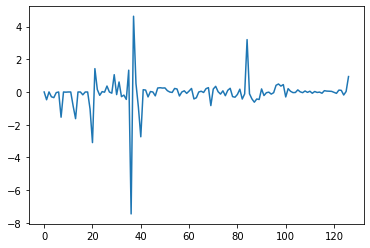

In [247]:
plt.plot(grid_result.best_estimator_.named_steps['model'].coef_.reshape(127,1))

# Break

In [152]:
def evaluate_model(model, X_train, y_train):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42) 
    scores = cross_val_score(model, X_train, y_train, scoring=metric, cv=cv, n_jobs=-1) 
    return scores

In [153]:
# evaluate_model(model, X_train, y_train)

In [103]:
def get_models():
  models = dict()
  for i in range(X.shape[1]-51,X.shape[1]-1):
    steps = [('preprocess',ct),
        ('pca', PCA(n_components=i)),
        ('model', LogisticRegression(solver='liblinear'))
    ]
    models['PCA features:'+str(i)] = Pipeline(steps=steps)
  return models

>PCA features:66 0.808 (0.016)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:67 0.819 (0.019)
>PCA features:68 0.833 (0.018)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:69 0.834 (0.019)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:70 0.837 (0.016)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:71 0.868 (0.015)
>PCA features:72 0.868 (0.016)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:73 0.868 (0.016)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:74 0.868 (0.016)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:75 0.868 (0.016)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:76 0.867 (0.016)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:77 0.867 (0.016)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:78 0.866 (0.014)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:79 0.866 (0.014)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:80 0.868 (0.014)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:81 0.868 (0.013)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:82 0.869 (0.015)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:83 0.868 (0.013)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:84 0.871 (0.014)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:85 0.886 (0.018)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:86 0.909 (0.013)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:87 0.912 (0.013)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:88 0.911 (0.013)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:89 0.912 (0.013)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:90 0.912 (0.012)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:91 0.913 (0.012)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:92 0.913 (0.012)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:93 0.913 (0.012)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:94 0.915 (0.012)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:95 0.915 (0.012)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:96 0.914 (0.013)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:97 0.914 (0.012)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:98 0.914 (0.012)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:99 0.914 (0.012)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:100 0.914 (0.012)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:101 0.915 (0.012)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:102 0.914 (0.012)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:103 0.914 (0.012)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:104 0.915 (0.012)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:105 0.919 (0.012)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:106 0.921 (0.011)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:107 0.922 (0.011)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:108 0.921 (0.011)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:109 0.921 (0.011)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:110 0.921 (0.011)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:111 0.921 (0.011)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:112 0.926 (0.012)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:113 0.925 (0.012)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:114 0.926 (0.012)


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:115 0.926 (0.012)


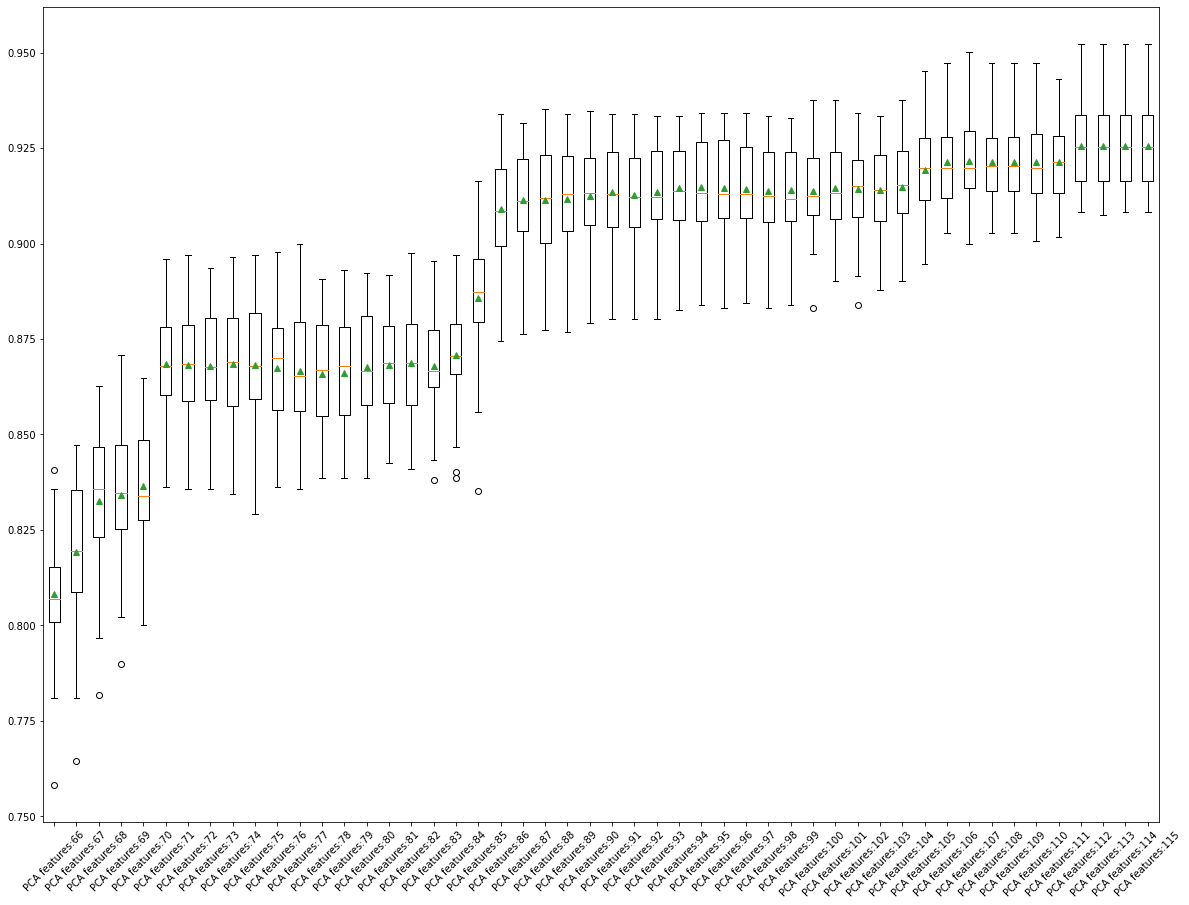

In [104]:
# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print(f'>{name} {np.mean(scores):.4f} {np.mean(scores):.4f}')
    
# plot model performance for comparison
plt.figure(figsize=(20,15))
plt.boxplot(results, labels=names, showmeans=True)
plt.xticks(rotation=45)
plt.show()

>PCA features:66 0.9806 0.9806
>PCA features:67 0.9821 0.9821


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:68 0.9839 0.9839


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:69 0.9840 0.9840


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:70 0.9840 0.9840


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:71 0.9868 0.9868


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:72 0.9869 0.9869


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:73 0.9868 0.9868


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:74 0.9868 0.9868


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:75 0.9868 0.9868


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:76 0.9868 0.9868


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:77 0.9869 0.9869


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:78 0.9871 0.9871


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:79 0.9871 0.9871


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:80 0.9871 0.9871


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:81 0.9871 0.9871


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:82 0.9871 0.9871


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:83 0.9873 0.9873


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:84 0.9875 0.9875


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:85 0.9888 0.9888


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:86 0.9911 0.9911


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:87 0.9908 0.9908


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:88 0.9907 0.9907


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:89 0.9908 0.9908


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:90 0.9908 0.9908


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:91 0.9908 0.9908


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:92 0.9907 0.9907


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:93 0.9907 0.9907


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:94 0.9907 0.9907


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:95 0.9908 0.9908


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:96 0.9908 0.9908


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:97 0.9908 0.9908


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:98 0.9908 0.9908


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:99 0.9908 0.9908


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:100 0.9908 0.9908


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:101 0.9908 0.9908


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:102 0.9908 0.9908


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:103 0.9909 0.9909


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:104 0.9911 0.9911


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:105 0.9919 0.9919


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:106 0.9922 0.9922


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:107 0.9922 0.9922


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:108 0.9922 0.9922


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:109 0.9922 0.9922


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:110 0.9923 0.9923


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:111 0.9923 0.9923


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:112 0.9927 0.9927


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:113 0.9927 0.9927


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:114 0.9927 0.9927


/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


>PCA features:115 0.9927 0.9927


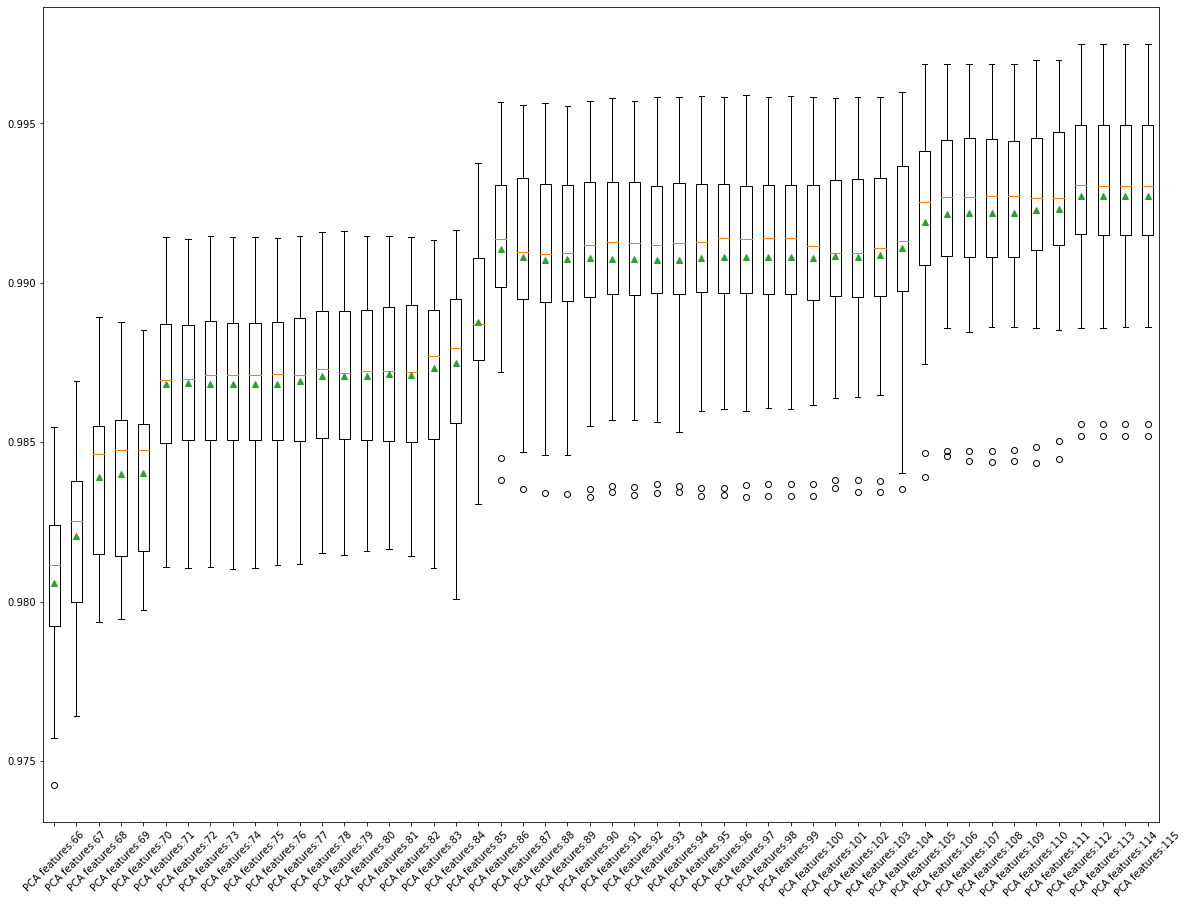

In [111]:
# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print(f'>{name} {np.mean(scores):.4f} {np.mean(scores):.4f}')
    
# plot model performance for comparison
plt.figure(figsize=(20,15))
plt.boxplot(results, labels=names, showmeans=True)
plt.xticks(rotation=45)
plt.show()

In [67]:
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# model = LogisticRegression(solver='liblinear')

# pipe = Pipeline(steps=[
#     ('preprocess',ct),
#     ('pca', PCA()),
#     ('LR', model)
# ])

# scores = cross_val_score(pipe, X_train, y_train, scoring=metric, cv=cv, n_jobs=-1) 
# print('Mean F2 Score: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
# print()
# print(scores)

# END